In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import plotly.graph_objs as go
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from plotly.subplots import make_subplots
from scipy.interpolate import Rbf
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
import datetime as dt
from datetime import date

In [47]:
#Helper functions

def depth_zone(d: float) -> str:
    """
    Classify the input as one of "Epipelagic", "Mesopelagic", "Bathypelagic"
    
    Input:
        d: float
            depth of sea, between 0 and 2000
    Return:
        zone: str
            one of "Epipelagic", "Mesopelagic", and "Bathypelagic"
    """
    if 0<= d <= 200:
        return "Epipelagic"
    elif 200 < d <= 1000:
        return "Mesopelagic"
    else:
        return "Bathypelagic"
    
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(dat: dt.datetime) -> str:
    """
    Returns the season of a particular date
    
    Input:
        date: datetime
            a date
    Return:
        season: str
    """
    if isinstance(dat, dt.datetime):
        dat = dat.date()
    dat = dat.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dat <= end)

In [48]:
def fetch_data(start_time: str, end_time: str, attribute: str,
               min_lon: float = -180, max_lon: float = 180, 
               min_lat: float = -90, max_lat: float = 90, 
              min_dep: float = 0, max_dep: float = 2000, ) -> pd.DataFrame:
    """
    Fetch Argo data using the API, with the specified locations, 
    time frame, depth, and attributes.
    
    Inputs:
        start_time, end_time: str, required
            the desired time frame. Should be in format 'yyyy-mm-dd'
        attribute: str, required
            The desired type of attributes from one of 'salinity' or 'temp'.
        min_lon, max_lon: float
            the desired range of longitudes between -180 and 180
        min_lat, max_lat: float
            the desired range of latitudes between -90 and 90
        min_depth, max_depth: float
            the desired depth between 0 and 2000
    
    Return:
        result: pd.DataFrame
            A data frame containing float no., season, location, depth (m), depth zone, 
            temp/salinity
    """
    
    #Check input
    assert -180 <= min_lon <= max_lon <= 180, "Please enter valid min_lon or max_lon" 
    assert -90 <= min_lat <= max_lat <= 90, "Please enter valid min_lat or max_lat" 
    assert 0 <= min_dep <= max_dep <= 2000, "Please enter valid min_dep or max_dep" 
    
    try:
        dt.datetime.strptime(start_time, "%Y-%m-%d")
        dt.datetime.strptime(end_time, "%Y-%m-%d")
    except:
        raise Exception("Please enter a valid start_time or end_time.")
        
    assert attribute in ["salinity", "temp"]
    
    #Fetch data from Argo API and store in xarr as an xarray
    reg = [min_lon, max_lon, min_lat, max_lat, min_dep, max_dep, start_time, end_time]
    # print("Downloading data from Argo...")
    xarr = ArgoDataFetcher().region(reg).to_xarray()
    df = xarr.to_dataframe()[["PRES", "PSAL", "TEMP", "LATITUDE", "LONGITUDE", "TIME"]]
    
    #TODO: Check there are enough points. How many points should we aim for?
    
    #Classify based on depth
    df["Depth Zone"] = df["PRES"]
    
    #Classify based on season
    df["Season"] = df["TIME"].apply(get_season)
    
    #TODO: Check for coastlines
    
    #Get the desired attributes
    if attribute == "salinity":
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "PSAL"]]
    else:
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "TEMP"]]
    
    return df

In [91]:
data = fetch_data('2012-06-01', '2012-12-01', "temp", -83, 29, 46, 73, 0, 2000)

In [92]:
data

,TIME,PRES,LATITUDE,LONGITUDE,Depth Zone,Season,TEMP
N_POINTS,,,,,,,
0,2012-06-01 01:27:00,5.900000,55.655998,-42.094002,5.900000,Spring,5.626
1,2012-06-01 01:27:00,9.500000,55.655998,-42.094002,9.500000,Spring,5.625
2,2012-06-01 01:27:00,19.500000,55.655998,-42.094002,19.500000,Spring,5.625
3,2012-06-01 01:27:00,27.500000,55.655998,-42.094002,27.500000,Spring,5.630
4,2012-06-01 01:27:00,40.599998,55.655998,-42.094002,40.599998,Spring,5.630
...,...,...,...,...,...,...,...
423683,2012-11-30 22:37:00,1888.000000,58.261000,-46.941000,1888.000000,Fall,3.188
423684,2012-11-30 22:37:00,1913.000000,58.261000,-46.941000,1913.000000,Fall,3.175
423685,2012-11-30 22:37:00,1938.000000,58.261000,-46.941000,1938.000000,Fall,3.158


In [95]:
data_ave = data.groupby(['LATITUDE', 'LONGITUDE', 'Depth Zone', 'Season'])['TEMP'].mean().reset_index()

In [98]:
data_ave['Label'] = data_ave.groupby(['LATITUDE', 'LONGITUDE']).ngroup()

In [70]:
filtered_df = data_ave[data_ave['Label'].isin(range(1, 7))]

In [71]:
fig = px.scatter_3d(filtered_df, x='LATITUDE', y='LONGITUDE', z='Depth Zone', color='TEMP', opacity=0.7)
fig.update_layout(scene=dict(xaxis_title='Latitude', 
                             yaxis_title='Longitude', 
                             zaxis_title='Depth Zone',
                             zaxis=dict(autorange='reversed')))

fig.show()

In [100]:
one = data_ave[data_ave['Label']==0]

In [105]:
one

,LATITUDE,LONGITUDE,Depth Zone,Season,TEMP,Label
0,46.002,-7.444,5.0,Fall,15.417,0
1,46.002,-7.444,6.0,Fall,15.416,0
2,46.002,-7.444,8.0,Fall,15.417,0
3,46.002,-7.444,10.0,Fall,15.418,0
4,46.002,-7.444,12.0,Fall,15.419,0
...,...,...,...,...,...,...
139,46.002,-7.444,1910.0,Fall,4.172,0
140,46.002,-7.444,1930.0,Fall,4.117,0
141,46.002,-7.444,1950.0,Fall,3.991,0
142,46.002,-7.444,1970.0,Fall,3.964,0


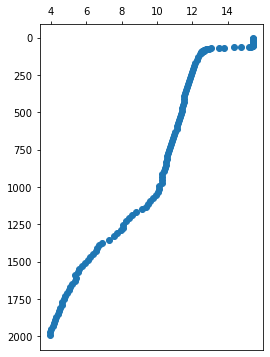

In [102]:
fig = plt.figure(figsize=(4, 6))
plt.scatter(one['TEMP'], one['Depth Zone'])
plt.gca().invert_yaxis()
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tick_params(axis='both', top=True, bottom=False)

In [131]:
data_old = fetch_data('2000-06-01', '2000-12-01', "temp", -83, 29, 46, 73, 0, 2000)

In [132]:
data_old_ave = data_old.groupby(['LATITUDE', 'LONGITUDE', 'Depth Zone', 'Season'])['TEMP'].mean().reset_index()

In [133]:
data_old_ave['Label'] = data_old_ave.groupby(['LATITUDE', 'LONGITUDE']).ngroup()

In [134]:
one_old = data_old_ave[(data_old_ave['Season']=='Fall')]

In [135]:
one_old = one_old[(one_old['Label']==7)]

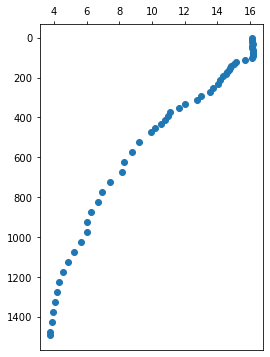

In [136]:
fig = plt.figure(figsize=(4, 6))
plt.scatter(one_old['TEMP'], one_old['Depth Zone'])
plt.gca().invert_yaxis()
plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tick_params(axis='both', top=True, bottom=False)

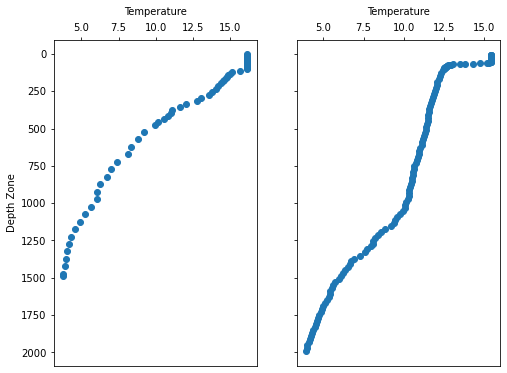

In [155]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharey=True)

axs[0].scatter(one_old['TEMP'], one_old['Depth Zone'])
axs[0].tick_params(axis='x', labeltop=True, labelbottom=False)
axs[0].tick_params(axis='both', top=True, bottom=False)
axs[0].set_ylabel('Depth Zone')
axs[0].set_xlabel('Temperature', horizontalalignment='center')
axs[0].xaxis.set_label_coords(0.5, 1.1)


axs[1].scatter(one['TEMP'], one['Depth Zone'])
axs[1].tick_params(axis='x', labeltop=True, labelbottom=False)
axs[1].tick_params(axis='both', top=True, bottom=False)
axs[1].set_xlabel('Temperature', horizontalalignment='center')
axs[1].xaxis.set_label_coords(0.5, 1.1)

axs[0].set_ylim(axs[0].get_ylim()[::-1])

plt.show()
